In [1]:
import pandas as pd
import os
import tqdm
import sys
sys.path.append("..")
import aux.models as aux
import scipy.stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
def ensure_monotonic(row):
    t = row['sojourn_time']
    c = row['cdf']
    if (t != 0) & (c == 0):
        return 1
    return c

In [3]:
def get_method_data(method):
    methodA = [f for f in os.listdir('sweep/method' + method)]
    methodA_data = {}
    for f in tqdm.tqdm_notebook(methodA):
        if f[-4:] == '.csv' and 'runtime' not in f:
            parts = f.split('=')
            rho = float(parts[4][:-4])
            R = int(parts[3][:-4])
            cdf = pd.read_csv('sweep/method' + method + '/' + f, index_col=0)
            cdf['cdf'] = cdf.apply(ensure_monotonic, axis=1)
            runtime = pd.read_csv('sweep/method' + method + '/' + f[:-4] + '-runtime.csv')['runtime'][0]
            methodA_data[(R, rho)] = {'cdf': cdf, 'runtime': runtime}
    return methodA_data

In [4]:
methodA_data = get_method_data('A')

In [5]:
methodB_data = get_method_data('B')

In [6]:
methodC_data = get_method_data('C')

In [7]:
methodD_data = get_method_data('D')

In [8]:
methodE_data = get_method_data('E')

In [9]:
methodF_data = get_method_data('F')

In [10]:
simulations = [f for f in os.listdir('sweep/simulation') if f != '.DS_Store']

In [11]:
timepoints = list(methodA_data[(8, 0.82)]['cdf']['sojourn_time'])
simulation_means = {}
simulation_data = {}
for f in tqdm.tqdm_notebook(simulations):
    parts = f.split('=')
    rho = float(parts[2])
    R = int(parts[1][:-4])
    recs = []
    data = pd.read_csv('sweep/simulation/' + f + '/sim0_recs.pq', index_col=0)
    cdf = [scipy.stats.percentileofscore(data['service_time'], t)/100 for t in timepoints]
    simulation_data[(R, rho)] = pd.DataFrame({'cdf':cdf}, index=timepoints)
    simulation_means[(R, rho)] = data['service_time'].mean()

//anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [12]:
methods = {
    'A': methodA_data,
    'B': methodB_data,
    'C': methodC_data,
    'D': methodD_data,
    'E': methodE_data,
    'F': methodF_data,
}

In [13]:
Rs = []
rhos = []
runtimes = {l: [] for l in 'ABCDEF'}
errors = {l: [] for l in 'ABCDEF'}

possible_rhos = [r / 100 for r in range(1, 100)]
for R in tqdm.tqdm_notebook(range(1, 11)):
    for rho in possible_rhos:
        Rs.append(R)
        rhos.append(rho)
        for m in 'ABCDEF':
            runtimes[m].append(methods[m][(R, rho)]['runtime'])
            errors[m].append(aux.wasserstein_distance(methods[m][(R, rho)]['cdf']['cdf'], simulation_data[(R, rho)]['cdf'], 0.01))

In [14]:
data = pd.DataFrame({
    'R': Rs,
    'rho': rhos,
    'error A': errors['A'],
    'error B': errors['B'],
    'error C': errors['C'],
    'error D': errors['D'],
    'error E': errors['E'],
    'error F': errors['F'],
    'runtime A': runtimes['A'],
    'runtime B': runtimes['B'],
    'runtime C': runtimes['C'],
    'runtime D': runtimes['D'],
    'runtime E': runtimes['E'],
    'runtime F': runtimes['F']
})

In [15]:
data.to_csv('sweep_summary.csv')

# If `sweep_summary.csv` exists and is up to date, just run from here

In [16]:
data = pd.read_csv('sweep_summary.csv')
data

Unnamed: 0   R   rho   error A   error B       error C    error D  \
0             0   1  0.01  1.612425  0.751343  4.939988e-01   0.010740   
1             1   1  0.02  1.536486  0.713408  4.772685e-01   0.006959   
2             2   1  0.03  1.480849  0.689493  4.724948e-01   0.006730   
3             3   1  0.04  1.427236  0.663183  4.639587e-01   0.004009   
4             4   1  0.05  1.380256  0.642454  4.594237e-01   0.004399   
..          ...  ..   ...       ...       ...           ...        ...   
985         985  10  0.95  0.192887  0.766361  6.361890e-01  45.974089   
986         986  10  0.96  0.142255  0.837981  1.143511e+24  47.042814   
987         987  10  0.97  0.108505  0.914653  5.897328e-01  48.104481   
988         988  10  0.98  0.111034  1.075461  7.134414e-01  49.079575   
989         989  10  0.99  0.291996  1.278500  9.373615e-01  50.009596   

      error E       error F   runtime A   runtime B   runtime C  runtime D  \
0    0.158810  1.767209e-01  444.113597  418.545161   55.662494  94.650509   
1    0.175599  1.928002e-01  462.640879  492.657165   69.034827  94.756362   
2    0.174752  1.909460e-01  481.867444  484.544148   71.486549  94.486632   
3    0.174077  1.893171e-01  482.035989  479.403639   85.380339  96.434633   
4    0.168867  1.831971e-01  459.745312  463.390010  112.476029  95.721036   
..        ...           ...         ...         ...         ...        ...   
985  1.225417  1.511618e-01   57.199567  410.814310  433.094308  55.481309   
986  1.154051  2.221500e+42   55.436074  222.727990  511.633541  55.497506   
987  1.077622           NaN   51.845491  191.953340  567.128856  56.707200   
988  0.917045           NaN   55.569801  181.111729  457.238893  56.054087   
989  0.714227           NaN   57.027185  163.891496  406.302473  54.659237   

     runtime E  runtime F  
0    94.928611  93.933656  
1    94.844352  94.249370  
2    94.651177  94.133553  
3    96.196674  93.507941  
4    95.757402  93.591410  
..         ...        ...  
985  33.168226  28.060713  
986  33.238043  28.181665  
987  33.224430  28.312266  
988  33.090287  59.277272  
989  33.279681  28.256113  

[990 rows x 15 columns]

# Comparing Methods A, B, C, D, E, F, and Simulation:

In [17]:
def plot_runtime_and_errors(R):
    cmap = matplotlib.cm.get_cmap('viridis')
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for i, m in enumerate('ABCDEF'):
        ax[0].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['error ' + m], linestyle='solid', c=cmap((i)/5), label=m)
    ax[0].set_xlabel('Traffic Intensity, ρ', fontsize=20)
    ax[0].set_ylabel('Wasserstein Distance', fontsize=20)
    ax[0].set_ylim(0, 4)
    for i, m in enumerate('ABCDEF'):
        ax[1].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['runtime ' + m], linestyle='solid', c=cmap((i)/5), label=m)
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.28, 0.85), fontsize=18, ncol=6)
    fig.suptitle(f'R = {R}', fontsize=28, y=1.15)
    plt.tight_layout()
    return fig

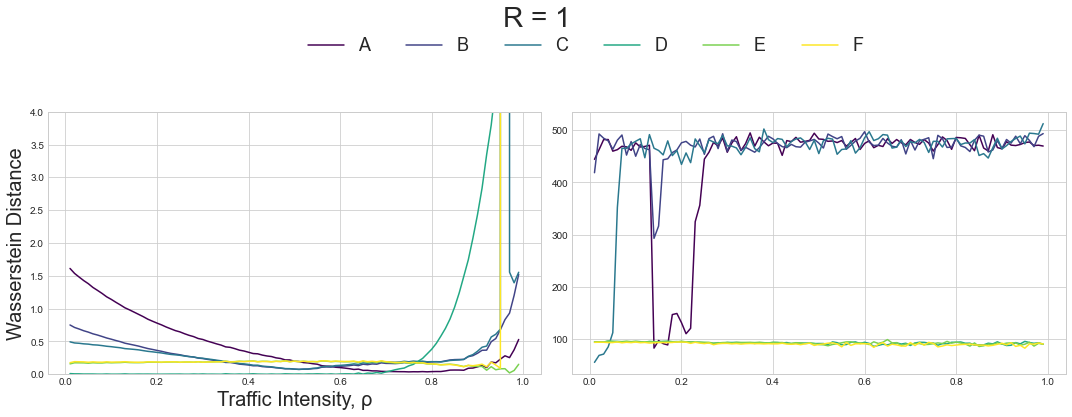

In [18]:
plot_runtime_and_errors(R=1);

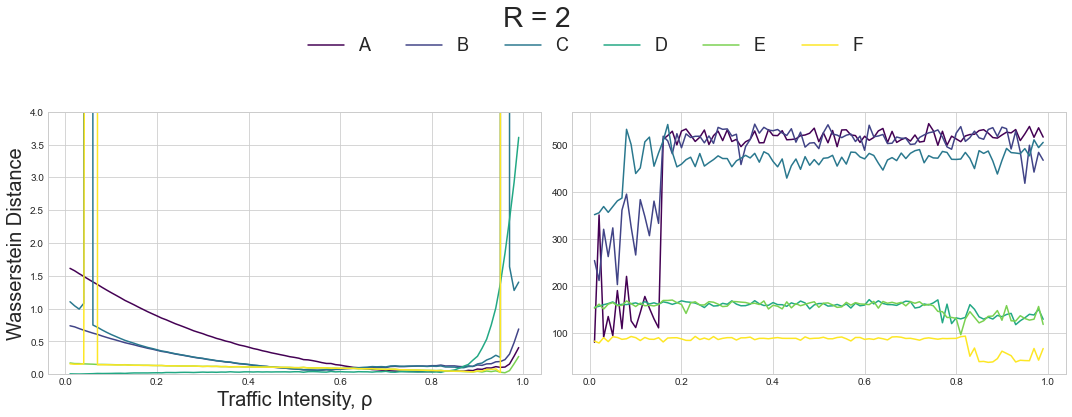

In [19]:
plot_runtime_and_errors(R=2);

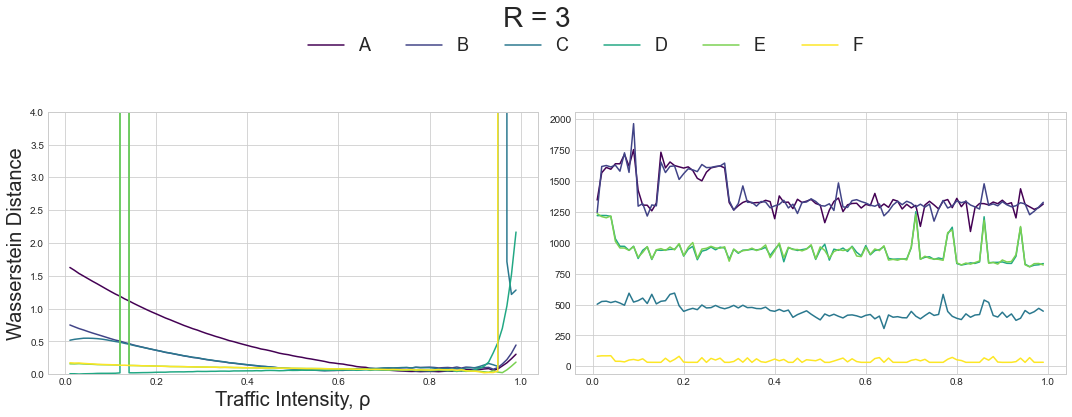

In [20]:
plot_runtime_and_errors(R=3);

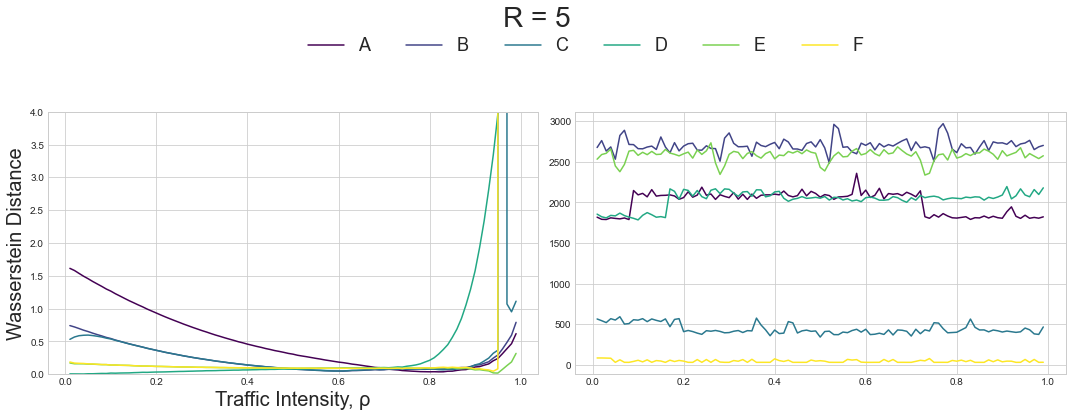

In [21]:
plot_runtime_and_errors(R=5);

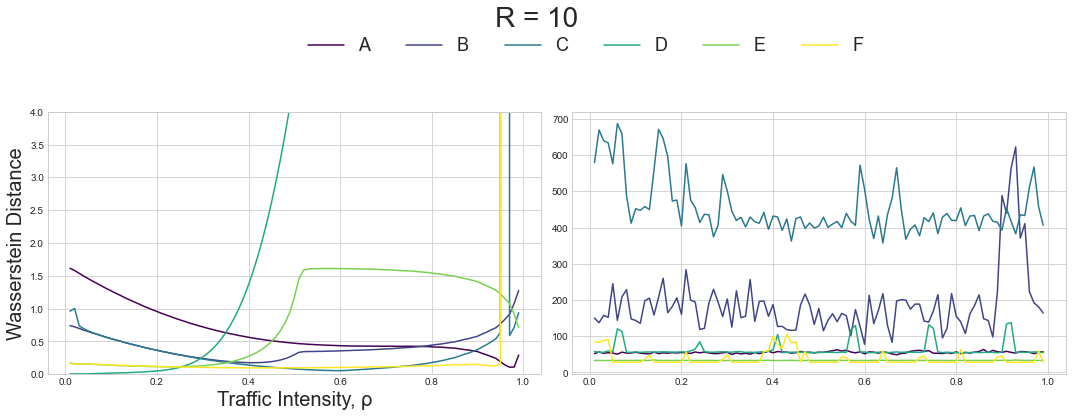

In [22]:
plot_runtime_and_errors(R=10);

# Just looking at each methods in isolation:

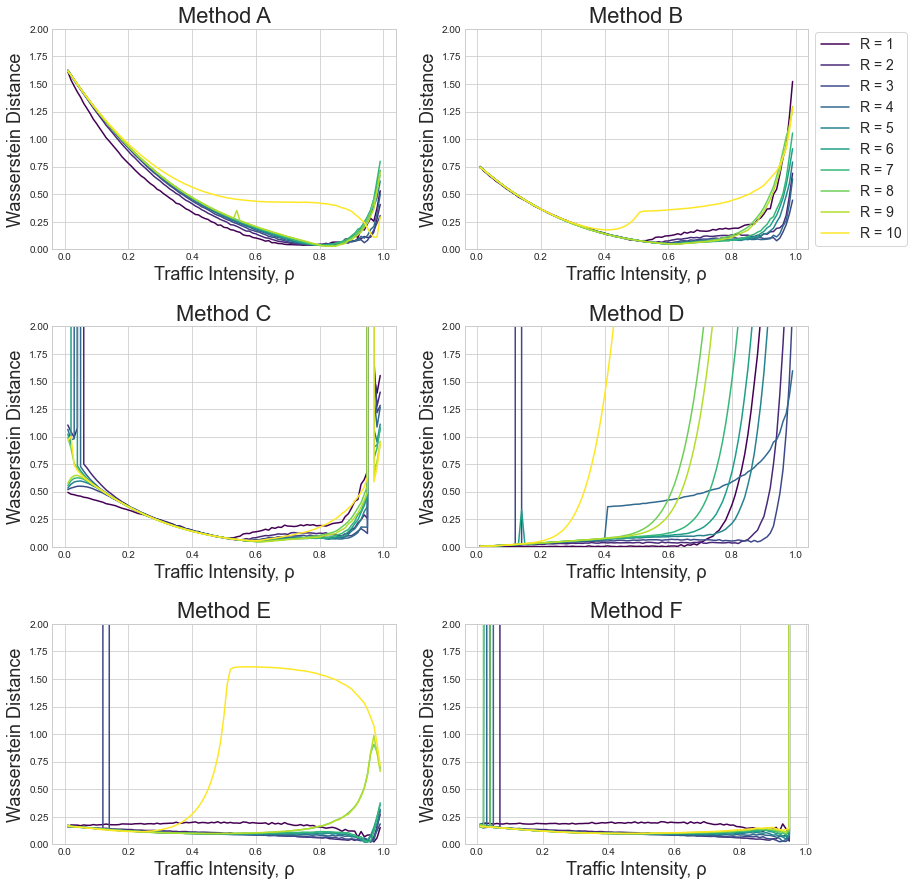

In [111]:
fig, axarr = plt.subplots(3, 2, figsize=(15, 15))
coords = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
vals = np.linspace(0, 1, 10)

for coord, m in zip(coords, 'ABCDEF'):
    for R, v in zip(range(1, 11), vals):
        col = plt.cm.viridis(v)
        axarr[coord].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['error ' + m], c=col, label=f'R = {R}')
    axarr[coord].set_ylim(0, 2)
    axarr[coord].set_xlabel('Traffic Intensity, ρ', fontsize=18)
    axarr[coord].set_ylabel('Wasserstein Distance', fontsize=18)
    axarr[coord].set_title("Method " + m, fontsize=22)

axarr[(0, 0)].legend(fontsize=14, loc='center left', bbox_to_anchor=(2.2, 0.5), ncol=1, frameon=True)
plt.subplots_adjust(left=0.2, hspace=0.35)
plt.savefig('compare_accuracies.pdf')

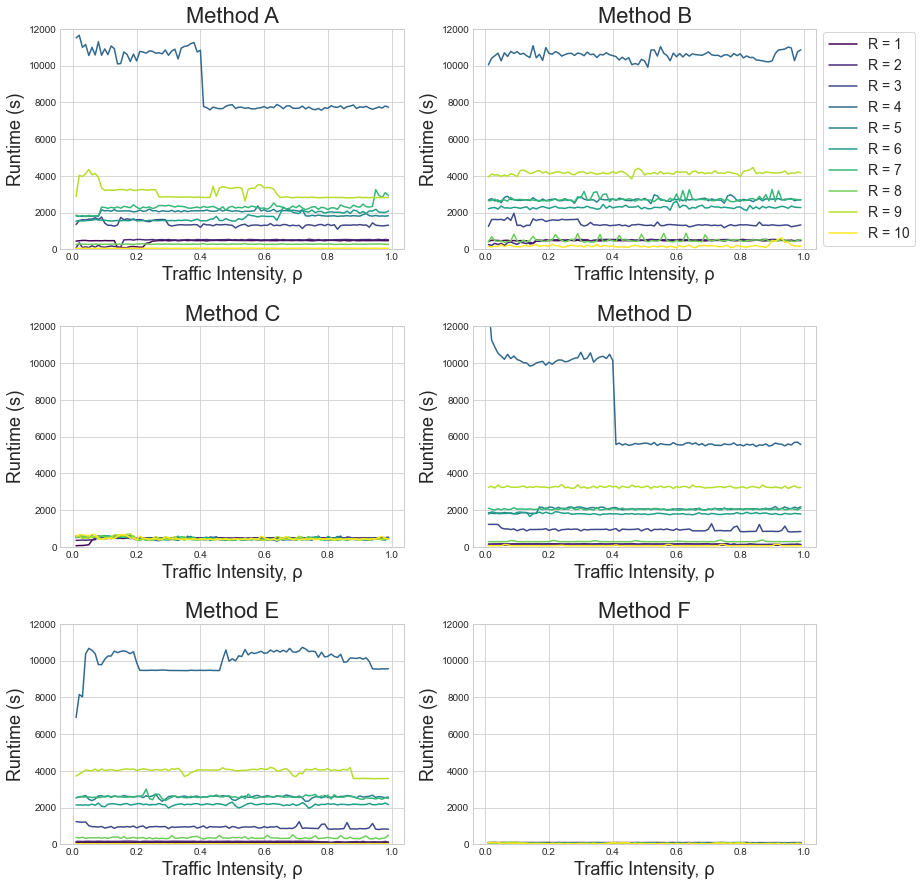

In [112]:
fig, axarr = plt.subplots(3, 2, figsize=(15, 15))
coords = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
vals = np.linspace(0, 1, 10)

for coord, m in zip(coords, 'ABCDEF'):
    for R, v in zip(range(1, 11), vals):
        col = plt.cm.viridis(v)
        axarr[coord].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['runtime ' + m], c=col, label=f'R = {R}')
    axarr[coord].set_ylim(0, 12000)
    axarr[coord].set_xlabel('Traffic Intensity, ρ', fontsize=18)
    axarr[coord].set_ylabel('Runtime (s)', fontsize=18)
    axarr[coord].set_title("Method " + m, fontsize=22)

axarr[(0, 0)].legend(fontsize=14, loc='center left', bbox_to_anchor=(2.2, 0.5), ncol=1, frameon=True)
plt.subplots_adjust(left=0.2, hspace=0.35)
plt.savefig('compare_runtimes.pdf')